STAGE -2 

Using device: cuda
Found classes: ['ALL', 'Brain Cancer', 'Breast Cancer', 'Cervical Cancer', 'Kidney Cancer', 'Lung and Colon Cancer', 'Lymphoma', 'Oral Cancer']
Number of classes: 8
Starting training...
Epoch [1/10], Loss: 0.0912
Epoch [2/10], Loss: 0.0315
Epoch [3/10], Loss: 0.0291
Epoch [4/10], Loss: 0.0221
Epoch [5/10], Loss: 0.0187
Epoch [6/10], Loss: 0.0190
Epoch [7/10], Loss: 0.0213
Epoch [8/10], Loss: 0.0143
Epoch [9/10], Loss: 0.0198
Epoch [10/10], Loss: 0.0172
Training complete.


Classification Report:
                       precision    recall  f1-score   support

                  ALL       1.00      1.00      1.00      3958
         Brain Cancer       1.00      1.00      1.00      3056
        Breast Cancer       0.98      0.98      0.98      1998
      Cervical Cancer       0.99      1.00      1.00      5038
        Kidney Cancer       1.00      1.00      1.00      1970
Lung and Colon Cancer       1.00      1.00      1.00      5014
             Lymphoma       0.99      

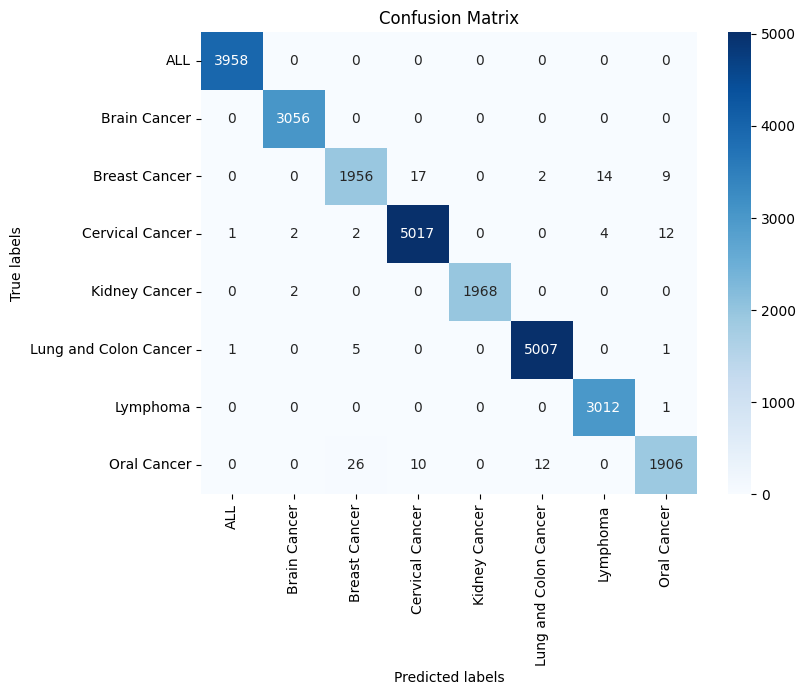


Model saved as organ_classifier_cnn.pth


In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Config
DATA_DIR = '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer'    # <-- new dataset
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Load dataset
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

print(f"Found classes: {class_names}")
print(f"Number of classes: {num_classes}")

# Split into train & test (80/20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Define custom CNN
class CancerCNN(nn.Module):
    def __init__(self, num_classes):
        super(CancerCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*16*16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model, loss, optimizer
model = CancerCNN(num_classes=num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}")

print("Training complete.\n")

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report & confusion matrix
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Save model
torch.save(model.state_dict(), "organ_classifier_cnn.pth")
print("\nModel saved as organ_classifier_cnn.pth")


TESTING

In [37]:
from PIL import Image

# Path to unseen image
IMAGE_PATH = '/kaggle/input/dataset/train/Normal/Normal_100x_1.jpg'  # <-- change to your test image path

# Load and preprocess
image = Image.open(IMAGE_PATH).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(DEVICE)  # shape: (1, 3, 128, 128)

# Load model from saved file (if model already in memory, you can skip re-loading)
model = CancerCNN(num_classes=num_classes).to(DEVICE)
model.load_state_dict(torch.load("organ_classifier_cnn.pth", map_location=DEVICE))
model.eval()

# Predict
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_class = class_names[predicted.item()]

print(f"✅ Predicted organ cancer type: {predicted_class}")


✅ Predicted organ cancer type: Oral Cancer
